<a href="https://colab.research.google.com/github/Bhavana-Kolli/22035573_Final-Project_Stock-Market/blob/main/22035573_Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
# Import libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from itertools import product

# Stocks were imported from Yahoo Finance using yfinance
import yfinance as yf


# **Functions**

In [2]:

# Function to plot the closing price, volume, and moving averages
def plot_stock_data(stock_data, stock_name="Stock"):
    """
    Plotting the closing price, volume, and moving averages for a given stock.
    """

    # Calculate moving averages
    stock_data['Close: 30 Day MA'] = stock_data['Close'].rolling(window=30).mean()
    stock_data['Close: 60 Day MA'] = stock_data['Close'].rolling(window=60).mean()
    stock_data['Close: 100 Day MA'] = stock_data['Close'].rolling(window=100).mean()

    plt.figure(figsize=(10, 12))

    # Plot the closing price
    plt.subplot(3, 1, 1)
    plt.plot(stock_data['Close'], label='Closing Price')
    plt.ylabel('Stock Prices')
    plt.xlabel('Year')
    plt.title(f"Closing Price of {stock_name} Stock")
    plt.legend()

    # Plot the trading volume
    plt.subplot(3, 1, 2)
    plt.plot(stock_data['Volume'], label='Volume Traded')
    plt.ylabel('Volume')
    plt.xlabel('Year')
    plt.title(f"Volume Traded for {stock_name} Stock in Past Decade")
    plt.legend()

    # Plot the moving averages
    plt.subplot(3, 1, 3)
    plt.plot(stock_data['Close'], label='Closing Price')
    plt.plot(stock_data['Close: 30 Day MA'], label='30 Day MA')
    plt.plot(stock_data['Close: 60 Day MA'], label='60 Day MA')
    plt.plot(stock_data['Close: 100 Day MA'], label='100 Day MA')
    plt.ylabel('Stock Prices')
    plt.xlabel('Year')
    plt.title(f"Moving Averages for {stock_name} Stock")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Function for Random Forest hyperparameter tuning
def randomforest_hyperparameter_tuning(X_train, y_train):
    """
    Performs hyperparameter tuning for a Random Forest Regressor using GridSearchCV.

    Returns: A Random Forest model with the best found hyperparameters.

    """
    # Define a dictionary of hyperparameters to tune
    param_grid = {
        # Number of trees in the forest
        'n_estimators': [50, 100, 150],
        # Maximum depth of each tree
        'max_depth': [None, 10, 20],
        # Minimum samples required to split a node
        'min_samples_split': [2, 5, 10]
    }
    # Initialize a Random Forest Regressor with random state as '40'
    rf = RandomForestRegressor(random_state=40)
    # Set up GridSearchCV with 5-fold cross-validation and negative MSE as the scoring metric
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    # Fit the grid search to find the best hyperparameters
    grid_search.fit(X_train, y_train)
    # Return the model with the best found parameters
    return grid_search.best_estimator_


# Function for Support Vector Machine (SVM) Hyperparameter tuning
def svm_hyperparameter_tuning(X_train, y_train):
    """
    Performs hyperparameter tuning for an SVM Regressor using GridSearchCV.

    Returns: An SVM model with the best found hyperparameters.

    """
    # Define a dictionary of hyperparameters to tune
    param_grid = {
        # Regularization parameter
        'C': [1, 10, 100],
        # Kernel coefficient
        'gamma': [0.01, 0.1, 1],
        # Epsilon in the epsilon-SVR model
        'epsilon': [0.1, 0.2, 0.5]
    }
    # Initialize an SVR model with radial basis function kernel
    svm = SVR(kernel='rbf')
    # Set up GridSearchCV with 5-fold cross-validation and negative MSE as the scoring metric
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    # Fit the grid search to find the best hyperparameters
    grid_search.fit(X_train, y_train)
    # Return the model with the best found parameters
    return grid_search.best_estimator_



# Function to create the hyperparameter grid for LSTM model
def lstm_hyperparameter_grid():
    """
    Create and return hyperparameter grid for tuning.
    Returns a list of parameter combinations.
    """
    # Define the ranges for the hyperparameters
    param_grid = {
        # Number of LSTM units to test
        "lstm_units": [32, 64],
        # Batch sizes to test during training
        "batch_size": [32, 64],
        # Learning rates to evaluate
        "learning_rate": [0.0005, 0.0001]
    }
    # Generate all combinations of hyperparameter values using Cartesian product
    param_combinations = list(product(
        param_grid["lstm_units"],
        param_grid["batch_size"],
        param_grid["learning_rate"]
    ))
    return param_combinations

# Function to train and evaluate an LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, lstm_units, batch_size, learning_rate):
    """
    Train an LSTM model using specified hyperparameters and evaluate it on validation data.
    Returns:
        val_mse: Mean Squared Error on the validation data.
        accuracy_percentage: Accuracy percentage derived from RMSE and mean target value.
    """
   # Reshape data to 3D format required for LSTM input (samples, timesteps, features)
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Build the LSTM model
    # Initialize the LSTM model
    model = Sequential()
    # Add an LSTM layer with the specified number of units
    model.add(LSTM(lstm_units, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    # Add a Dense output layer with a single neuron for regression tasks
    model.add(Dense(1))

    # Compile the model with Adam optimizer and Mean Squared Error loss function
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting and stop training when validation loss doesn't improve
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(
        X_train_lstm, y_train,
        validation_data=(X_val_lstm, y_val),
        epochs=50,
        batch_size=batch_size, verbose=0,
        callbacks=[early_stopping]
    )

    # Predict on validation data
    val_predictions = model.predict(X_val_lstm).flatten()
    val_mse = mean_squared_error(y_val, val_predictions)

    # Calculate RMSE and Accuracy Percentage
    rmse = np.sqrt(val_mse)
    mean_actual_value = np.mean(y_val)
    accuracy_percentage = 100 - ((rmse / mean_actual_value) * 100)

    return val_mse, accuracy_percentage

# Perform grid search to find the best parameters for lstm model
def lstm_grid_search(X_train, y_train, X_val, y_val):
    """
    Perform grid search over a range of hyperparameters to find the best combination.
    """
    # Generate all possible combinations of hyperparameters
    param_combinations = lstm_hyperparameter_grid()
    best_params = None
    # Initialize best accuracy
    best_accuracy = -float('inf')
    # Store results for logging
    results = []

    # Iterate through all parameter combinations
    for params in param_combinations:
        lstm_units, batch_size, learning_rate = params
        # Train the model and evaluate performance
        mse, accuracy = train_lstm_model(
            X_train, y_train, X_val, y_val,
            lstm_units, batch_size, learning_rate
        )
        # Log the results
        results.append((params, mse, accuracy))
        print(f"Params: {params} => MSE: {mse:.4f}, Accuracy: {accuracy:.2f}%")
        # Update the best parameters if the current accuracy is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params

    # Output best parameters and accuracy
    print("\nBest Parameters-------------------")
    print(f"LSTM Units: {best_params[0]}")
    print(f"Batch Size: {best_params[1]}")
    print(f"Learning Rate: {best_params[2]}")

    return best_params

# Train final model with best parameters and calculate metrics on the test set
def train_final_lstm_model(
    X_train, y_train, X_test, y_test,
    lstm_units, batch_size, learning_rate
):
    """
    Train a final LSTM model with the best parameters and calculate metrics on the test set.
    """
    # Reshape input data for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    model.fit(
        X_train_lstm, y_train,
        epochs=50,  # Use enough epochs to let the model converge
        batch_size=batch_size, verbose=1
    )
    # Summarize and Plot the LSTM model
    model.summary()
    plot_model(model)

    # Predict on the test set
    test_predictions = model.predict(X_test_lstm)

    test_mse = mean_squared_error(y_test, test_predictions)

    # Calculate RMSE and Accuracy Percentage
    rmse = np.sqrt(test_mse)
    mean_actual_value = np.mean(y_test)
    accuracy_percentage = 100 - ((rmse / mean_actual_value) * 100)

    return test_mse, rmse, accuracy_percentage, test_predictions





# **BAE Systems Plc**

## **Data Loading**

In [3]:
# Fetching the data of BAE Systems Plc from yahoo finance

# Define the ticker symbol
bae = "BA.L"

# Download the data for the specified date range
bae_data = yf.download(bae, start="2014-10-01", end="2024-10-01")

# Save the data to a CSV file
bae_data.to_csv('BAE_stock_data_10years.csv')

# Show the data
bae_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BA.L,BA.L,BA.L,BA.L,BA.L,BA.L
Date,,,,,,
2014-10-01 00:00:00+00:00,312.949188,463.200012,474.799988,462.100006,470.899994,6807389
2014-10-02 00:00:00+00:00,306.598297,453.799988,460.000000,453.000000,454.000000,9285952
2014-10-03 00:00:00+00:00,310.922394,460.200012,461.290985,453.299988,454.700012,6578201
2014-10-06 00:00:00+00:00,311.868164,461.600006,465.899994,458.500000,458.500000,6585452
2014-10-07 00:00:00+00:00,304.368805,450.500000,459.757996,445.000000,459.700012,11095801
...,...,...,...,...,...,...
2024-09-24 00:00:00+00:00,1255.620117,1267.500000,1276.500000,1261.849976,1273.500000,11342845
2024-09-25 00:00:00+00:00,1262.059204,1274.000000,1276.500000,1256.000000,1257.000000,6238942


In [4]:
# General information of BAE Systems Plc stock
bae_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2526 entries, 2014-10-01 00:00:00+00:00 to 2024-09-30 00:00:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, BA.L)  2526 non-null   float64
 1   (Close, BA.L)      2526 non-null   float64
 2   (High, BA.L)       2526 non-null   float64
 3   (Low, BA.L)        2526 non-null   float64
 4   (Open, BA.L)       2526 non-null   float64
 5   (Volume, BA.L)     2526 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 138.1 KB


In [5]:
# Summary stats for BAE Systems Plc stock
bae_data.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BA.L,BA.L,BA.L,BA.L,BA.L,BA.L
count,2526.000000,2526.000000,2526.000000,2526.000000,2526.000000,2.526000e+03
mean,568.384832,659.810301,666.216326,653.037293,659.922097,7.983746e+06
std,268.185360,235.550137,237.705318,233.742489,235.675575,4.108558e+06
min,295.382965,397.000000,406.399994,5.694000,398.600006,0.000000e+00
25%,402.103775,505.000000,511.000000,499.491997,505.500000,5.408591e+06
50%,460.407654,569.300018,574.000000,564.333527,568.200012,7.127968e+06
75%,675.781128,731.549988,741.170502,718.350021,731.250015,9.637130e+06
max,1386.878296,1400.000000,1415.250000,1395.500000,1403.500000,5.421986e+07


In [6]:
# Print the number of rows in the original data
print('Rows in original data = %d' % (bae_data.shape[0]))

# Drop rows with missing values
df = bae_data.dropna()

# Print the number of rows after discarding missing values
print('Rows after discarding missing values = %d' % (df.shape[0]))

Rows in original data = 2526
Rows after discarding missing values = 2526


## **Preprocessing**

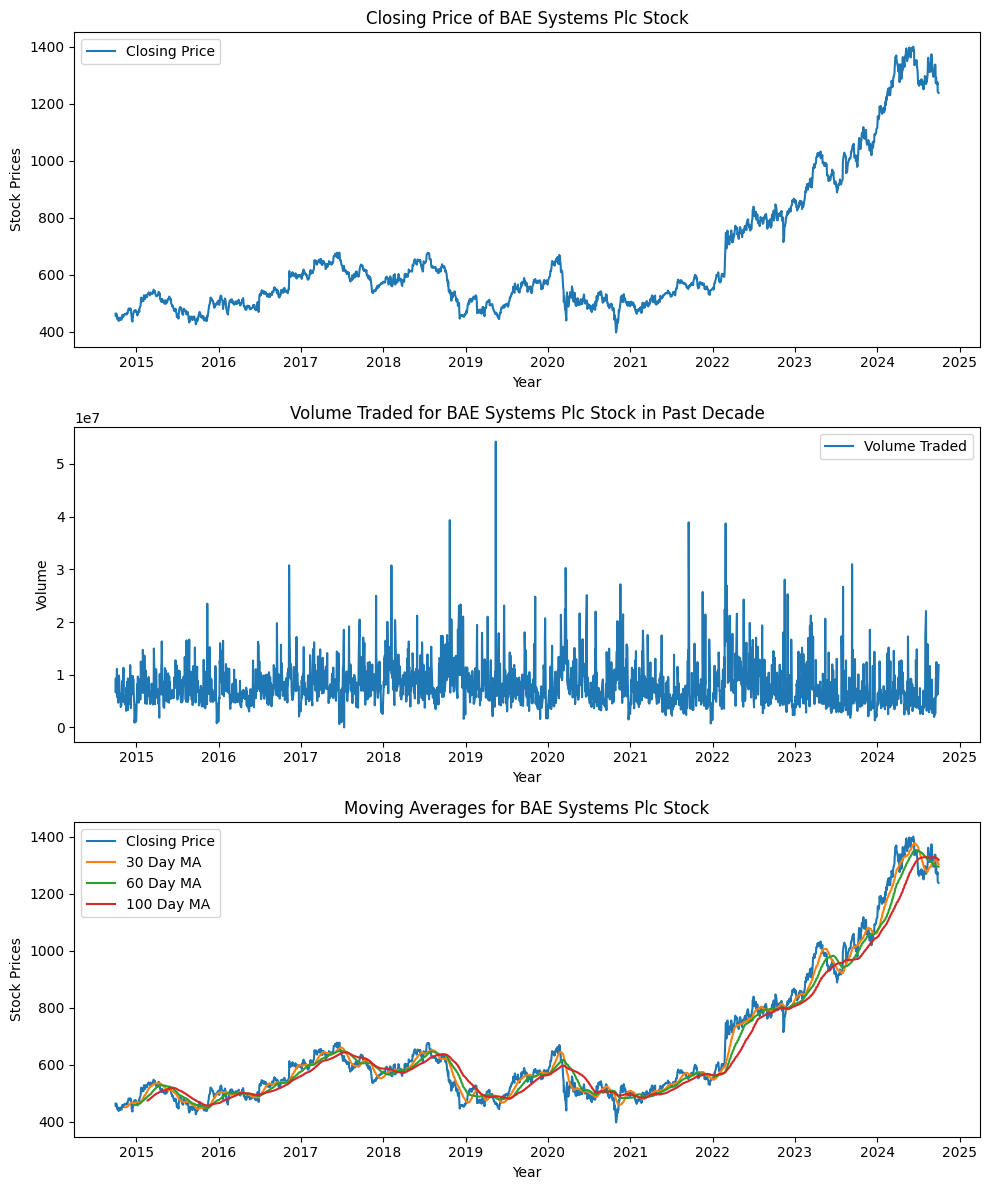

In [7]:
# Plotting the closing price and volume traded for BAE Systems Plc stock over 10 years.
plot_stock_data(bae_data, stock_name="BAE Systems Plc")


In [8]:
# Predict next day's price
bae_data['Target'] = bae_data['Close'].shift(-1)
bae_data.dropna(inplace=True)

# Normalize the data
scaler_bae = MinMaxScaler(feature_range=(0, 1))
scaled_data_bae = scaler_bae.fit_transform(bae_data)

# Split data into training and testing sets
train_size_bae = int(len(scaled_data_bae) * 0.8)
train_bae, test_bae = scaled_data_bae[:train_size_bae], scaled_data_bae[train_size_bae:]

X_train_bae, y_train_bae = train_bae[:, :-1], train_bae[:, -1]
X_test_bae, y_test_bae = test_bae[:, :-1], test_bae[:, -1]

# Calculate the mean of the actual values in y_test_bae
mean_actual_value = y_test_bae.mean()

## **Model Development**

### **Random Forest Model**

In [9]:
# Random Forest model for BAE Systems Plc stock
randomforest_bae = randomforest_hyperparameter_tuning(X_train_bae, y_train_bae)


Percentage Accuracy of Random Forest model for BAE Systems Plc Stock: 53.04%


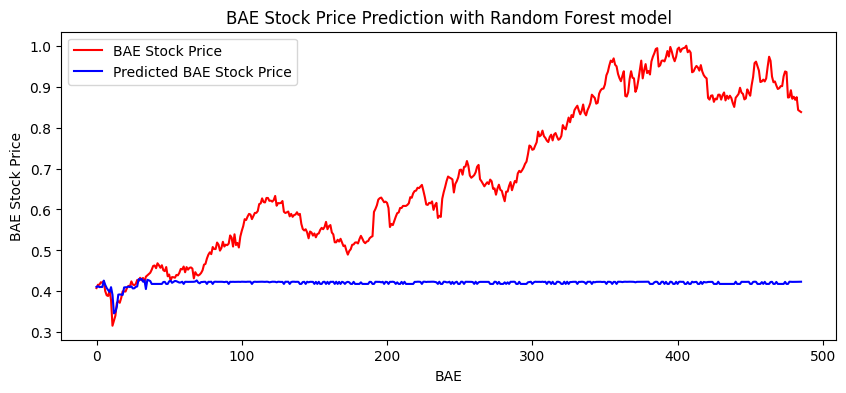

In [10]:
# Calculating mse, rmse, accuracy percentage for BAE Systems Plc stock with Random Forest model

# Calculating the Mean Squared Error on the test data
randomforest_mse_bae = mean_squared_error(y_test_bae, randomforest_bae.predict(X_test_bae))
# Calculating the Root Mean Squared Error (RMSE) from MSE
randomforest_rmse_bae = math.sqrt(randomforest_mse_bae)
# Calculating the accuracy percentage
rf_accuracy_percentage = 100 - ((randomforest_rmse_bae / mean_actual_value) * 100)

# Printing the accuracy percentage for the Random Forest model
print(f"Percentage Accuracy of Random Forest model for BAE Systems Plc Stock: {rf_accuracy_percentage:.2f}%")

# Plotting actual vs predicted for Random Forest model
plt.figure(figsize=(10, 4))
plt.plot(y_test_bae, color='red', label='BAE Stock Price')
plt.plot(randomforest_bae.predict(X_test_bae), color='blue', label='Predicted BAE Stock Price')
plt.title('BAE Stock Price Prediction with Random Forest model')
plt.xlabel('BAE')
plt.ylabel('BAE Stock Price')
plt.legend()
plt.show()

### **SVM Model**

In [11]:
# SVM model for BAE Systems Plc stock
svm_model_bae = svm_hyperparameter_tuning(X_train_bae, y_train_bae)


Percentage Accuracy of SVM model for BAE Systems Plc Stock: 73.25%


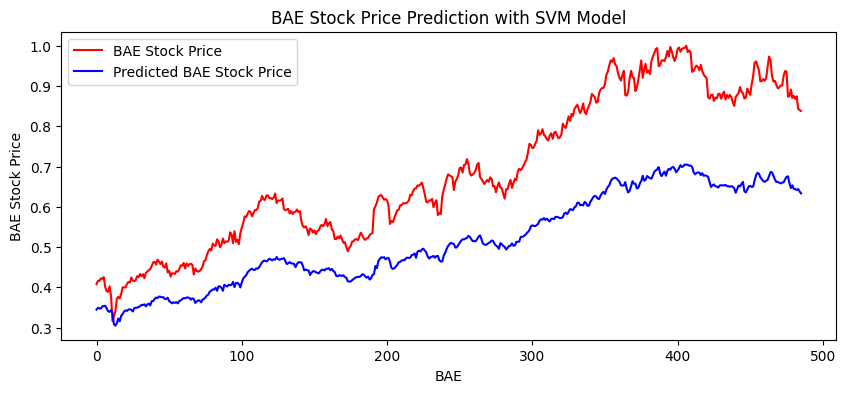

In [12]:
# Calculating mse, rmse, accuracy percentage for BAE Systems Plc stock with SVM model

# Calculating the Mean Squared Error on the test data
svm_mse_bae = mean_squared_error(y_test_bae, svm_model_bae.predict(X_test_bae))
# Calculating the Root Mean Squared Error (RMSE) from MSE
svm_rmse_bae = math.sqrt(svm_mse_bae)
# Calculating the accuracy percentage
svm_accuracy_percentage = 100 - ((svm_rmse_bae / mean_actual_value) * 100)

# Print the accuracy percentage for SVM model
print(f"Percentage Accuracy of SVM model for BAE Systems Plc Stock: {svm_accuracy_percentage:.2f}%")

# Plotting actual vs predicted for SVM model
plt.figure(figsize=(10, 4))
plt.plot(y_test_bae, color='red', label='BAE Stock Price')
plt.plot(svm_model_bae.predict(X_test_bae), color='blue', label='Predicted BAE Stock Price')
plt.title('BAE Stock Price Prediction with SVM Model')
plt.xlabel('BAE')
plt.ylabel('BAE Stock Price')
plt.legend()
plt.show()

### **LSTM Model**

In [13]:
# Scale the feature and target data using the fitted scaler
X_train_bae_scaled = scaler_bae.fit_transform(X_train_bae)
y_train_bae_scaled = scaler_bae.fit_transform(y_train_bae.reshape(-1, 1))


# Split scaled data into training, validation, and testing sets
# First, split into 70% training and 30% temporary set (temp) for further splitting
X_train, X_temp, y_train, y_temp = train_test_split(X_train_bae_scaled, y_train_bae_scaled, test_size=0.3, random_state=42)
# Next, split the temporary set into 50% validation and 50% testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Perform grid search to find the best parameters
print("Performing Grid Search...")
best_params = lstm_grid_search(X_train, y_train, X_val, y_val)



Performing Grid Search...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (32, 32, 0.0005) => MSE: 0.0007, Accuracy: 93.07%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (32, 32, 0.0001) => MSE: 0.0020, Accuracy: 88.06%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (32, 64, 0.0005) => MSE: 0.0011, Accuracy: 91.20%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (32, 64, 0.0001) => MSE: 0.0020, Accuracy: 88.21%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (64, 32, 0.0005) => MSE: 0.0006, Accuracy: 93.27%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (64, 32, 0.0001) => MSE: 0.0019, Accuracy: 88.56%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (64, 64, 0.0005) => MSE: 0.0009, Accuracy: 92.19%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (64, 64, 0.0001) => MSE: 0.0022, Accuracy: 87.58%

Best Parameters-------------------
LSTM Units: 64
Batch Size: 32
Learning Rate: 0.0005


In [14]:
# Use the best parameters for final training and testing

# Unpack the best hyperparameters from the grid search results
best_lstm_units, best_batch_size, best_learning_rate = best_params
# Train the final model using the best parameters found during the grid search
print("\nTraining Final Model with Best Parameters...")
final_mse, final_rmse, final_accuracy, predictions = train_final_lstm_model(
        X_train, y_train, X_test, y_test,
        best_lstm_units, best_batch_size, best_learning_rate
    )



Training Final Model with Best Parameters...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1190
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010
Epoch 16/50
43/43 ━━━━━━━━━━━━

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 64)                  │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,029 (222.77 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,020 (148.52 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



Final Model Metrics for BAE Systems Plc Stock:
MSE of LSTM model for BAE Systems Plc Stock: 0.0004
RMSE of LSTM model for BAE Systems Plc Stock: 0.0206
Accuracy Percentage of LSTM model for BAE Systems Plc Stock: 94.52%


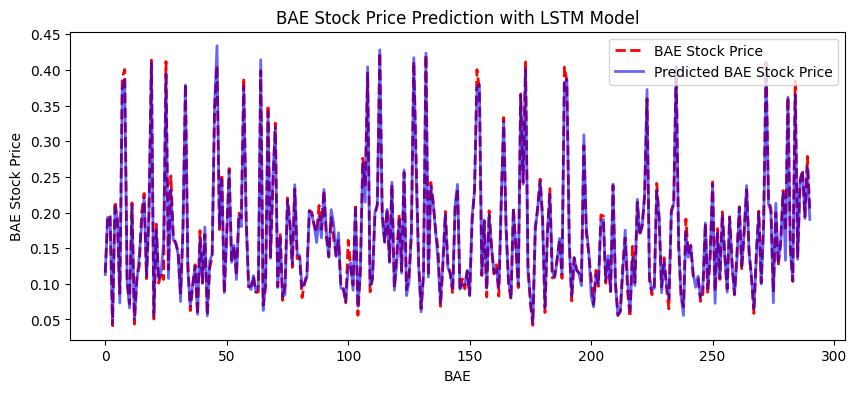

In [15]:
# Output the final evaluation metrics for the model
print("\nFinal Model Metrics for BAE Systems Plc Stock:")
print(f"MSE of LSTM model for BAE Systems Plc Stock: {final_mse:.4f}")
print(f"RMSE of LSTM model for BAE Systems Plc Stock: {final_rmse:.4f}")
print(f"Accuracy Percentage of LSTM model for BAE Systems Plc Stock: {final_accuracy:.2f}%")


# Inverse transform both y_test and predictions to original scale
y_test_original = scaler_bae.inverse_transform(y_test.reshape(-1, 1)).flatten()
predictions_original = scaler_bae.inverse_transform(predictions.reshape(-1, 1)).flatten()


# Plot the actual vs predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_original, color='red', label='BAE Stock Price', linestyle='dashed', linewidth=2)
plt.plot(predictions_original, color='blue', label='Predicted BAE Stock Price', linestyle='solid', linewidth=2, alpha=0.6)
plt.title('BAE Stock Price Prediction with LSTM Model')
plt.xlabel('BAE')
plt.ylabel('BAE Stock Price')
plt.legend()
plt.show()